In [101]:
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from sklearn.cluster import HDBSCAN

from util.general import list_to_parsed_set

In [102]:
# Boundaries
chi_communities = gp.read_file("data/chicago_comm_utm/chicago_comm_utm.shp")[
    ["NID", "geometry"]
]
chi_streets = gp.read_file(
    "data/chi_street_lines/geo_export_df3e19c4-8a1b-41de-be21-1d0b821afcfb.shp"
)
ucpd_patrol_area = gp.read_file("data/UCPD_patrol_area.geojson")

# Constants
CATEGORY_INFO = "Information"
CLUSTER_KEY = "hdb_cluster"
ESPG_NUM = 4326
FIGURE_SIZE = (25, 25)
VIEWPORT_X = (-87.63, -87.56)
VIEWPORT_Y = (41.77, 41.832)

In [103]:
all_df = pl.read_csv(
    "./data/incident_dump.csv",
).with_columns(
    pl.col("reported")
    .str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z")
    .dt.convert_time_zone("America/Chicago"),
    pl.col("reported_date").str.to_date("%Y-%m-%d"),
    pl.col("validated_location").str.split(",").cast(pl.List(pl.Float64)),
    pl.col("validated_location")
    .str.split(",")
    .cast(pl.List(pl.Float64))
    .apply(lambda v: v[1])
    .alias("longitude"),
    pl.col("validated_location")
    .str.split(",")
    .cast(pl.List(pl.Float64))
    .apply(lambda v: v[0])
    .alias("latitude"),
)
all_df = all_df.filter(~pl.col("validated_address").is_null()).filter(
    pl.col("incident") != CATEGORY_INFO
)

In [104]:
type_set = list_to_parsed_set(all_df["incident"].to_list())
type_set.remove(CATEGORY_INFO)
print(len(type_set))

301


In [105]:
VIOLENCE = sorted(
    [
        "Aggravated Assault of Police Officer",
        "Aggravated Assault of a Police Officer",
        "Aggravated Assault",
        "Aggravated Battery of Police Officer",
        "Aggravated Battery of a Police Officer",
        "Aggravated Battery of a Protected Employee",
        "Aggravated Battery to Police Officer",
        "Aggravated Battery",
        "Aggravated Discharge of a Firearm",
        "Aggravated Robbery",
        "Aggravated Vehicular Carjacking",
        "Aggravated Vehicular Hijacking",
        "Armed Robbery Arrest",
        "Armed Robbery",
        "Assault",
        "Attempted Aggravated Robbery",
        "Attempted Aggravated Vehicular Hijacking",
        "Attempted Armed Robbery",
        "Attempted Burglary",
        "Attempted Home Invasion",
        "Attempted Motor Vehicle Theft",
        "Attempted Robbery",
        "Attempted Strong Arm",
        "Attempted Theft from Motor Vehicle",
        "Attempted Theft from Person",
        "Attempted Theft of Motor Vehicle",
        "Attempted Theft",
        "Attempted Vehicular Hijacking",
        "Battery of Police Officer",
        "Battery of a Police Officer",
        "Battery to Police Officer",
        "Battery",
        "Battery-Simple",
        "Carjacking",
        "Harassment",
        "Hate Crime",
        "Hit and Run",
        "Home Invasion",
        "Homicide",
        "Murder",
        "Purse Snatch",
        "Reckless Discharge of Firearm",
        "Reckless Discharge of a Firearm",
        "Reckless Discharge of a Weapon",
        "Robbery Arrest",
        "Robbery",
        "Robbery-Aggravated",
        "Robbery-Strong Arm",
        "Shooting",
        "Shot Fired",
        "Simple Assault Battery",
        "Simple Assault",
        "Simple Battery",
        "Strong Arm",
        "Strong Armed",
        "Theft from Person",
        "Threat",
        "Unlawful Discharge of Firearm",
        "Unlawful Discharge of Weapon",
        "Unlawful Discharge of a Firearm",
        "Unlawful Discharge of a Weapon",
        "Unlawful Use of Firearm",
        "Unlawful Use of Weapon",
        "Unlawful Use of a Weapon Arrest",
        "Unlawful Use of a Weapon",
        "Vehicle Hijacking",
        "Vehicular Carjacking",
        "Vehicular Hijacking",
    ]
)

SEXUAL_ASSAULT_GENDER_BASED = sorted(
    [
        "Aggravated Criminal Sexual Assault",
        "Aggravated Domestic Assault",
        "Aggravated Domestic Battery",
        "Attempted Sexual Assault",
        "Criminal Sexual Abuse",
        "Criminal Sexual Assault",
        "Dating Violence",
        "Domestic Aggravated Assault",
        "Domestic Aggravated Battery",
        "Domestic Assault",
        "Domestic Battery",
        "Domestic Dispute",
        "Domestic Disturbance",
        "Domestic Issue",
        "Domestic",
        "Fondling",
        "Indecent Exposure",
        "Luring a Minor",
        "Sex Crime",
        "Sex Offender",
        "Sex Offense",
        "Sex Related",
        "Sexual Abuse",
        "Sexual Assault",
        "Stalking",
        "Violation of Order of Protection",
    ]
)

NARCOTICS = sorted(
    [
        "Deliver Narcotic",
        "Delivery of Cannabis",
        "Drug Law Violation",
        "Found Drug Paraphernalia",
        "Found Narcotic Paraphernalia",
        "Found Narcotic",
        "Found Suspect Marijuana",
        "Found Suspect Narcotic",
        "Narcotic Arrest",
        "Narcotic Delivery",
        "Narcotic",
        "Possession of Cannabis",
        "Possession of Controlled Substance",
        "Possession of Crack Cocaine",
        "Possession of Drug Paraphernalia",
        "Possession of Marijuana",
        "Possession of Narcotic with Intent to Deliver",
        "Possession of Narcotic",
        "Possession of a Controlled Substance",
        "Suspect Narcotic Found",
        "Suspect Narcotic",
    ]
)

OTHER = sorted(
    [
        "Accident Report",
        "Accidental Fire",
        "Accidental Injury",
        "Accidental Shooting",
        "Accidental",
        "Alarm",
        "Ambulance Request",
        "Animal Bite",
        "Arrest on Warrant",
        "Arrest",
        "Arson by Fire",
        "Arson",
        "Assault and Harassment by Electronic Means",
        "Assist Other Agency Motor Vehicle Theft and Recovery",
        "Assist Other Agency",
        "Attempt",
        "Attempted",
        "Automobile",
        "Bomb Threat",
        "Burglary",
        "Chemical Spill",
        "Child Abandonment",
        "Computer Fraud",
        "Counterfeit Check",
        "Counterfeit Document",
        "Credit Card Fraud",
        "Criminal Damage to Motor Vehicle",
        "Criminal Damage to Property",
        "Criminal Damage to Vehicle",
        "Criminal Defacement",
        "Criminal Trespass to Land",
        "Criminal Trespass to Motor Vehicle",
        "Criminal Trespass to Property",
        "Criminal Trespass to Residence",
        "Criminal Trespass to Vehicle",
        "Criminal Trespass",
        "Cutting Instrument",
        "Cyber Scam",
        "Cyberstalking",
        "DUI Arrest",
        "DUI",
        "Damage to City Property",
        "Damage to Personal Property",
        "Damage to Property",
        "Damage to UC Property",
        "Damage to UC Vehicle",
        "Damage to Vehicle",
        "Damage",
        "Damaged Property",
        "Death Investigation",
        "Deceptive Practice",
        "Deceptive",
        "Defacement",
        "Delayed Burglary",
        "Delayed Report",
        "Delayed Robbery",
        "Delayed",
        "Disorderly Conduct",
        "Disturbance",
        "Dog Bite",
        "Eavesdropping",
        "Electronic Means",
        "Elevator Entrapment",
        "Eluding Police",
        "Expired License",
        "Extortion",
        "Failure to Register",
        "False Fire Alarm",
        "False Police Report",
        "Financial Identity Theft",
        "Fire Alarm",
        "Fire",
        "Fleeing or Attempting to Elude Police",
        "Fleeing",
        "Foreign Steal",
        "Forged Prescription",
        "Forgery",
        "Found Key",
        "Found Person",
        "Found Property",
        "Found Wallet",
        "Found Weapon",
        "Found",
        "Fraud",
        "Fraudulent Check",
        "Harassing Email Message",
        "Harassing Email",
        "Harassing Message",
        "Harassing Phone Call",
        "Harassing Telephone Call",
        "Harassment Via Electronic Means",
        "Harassment by Electronic Means",
        "Harassment by Telephone",
        "Haz Mat Event",
        "Haz Mat Incident",
        "Haz Mat",
        "Haz-Mat Incident",
        "Hazardous Material Event",
        "Hazardous Material Incident",
        "Hit and Run Property Damage",
        "Hit and Run Traffic Crash",
        "Identity Theft",
        "Ill Person",
        "Illegal Consumption by Minor",
        "Illegal Possession of Cash Card",
        "Illness",
        "Impersonation",
        "Information Criminal Damage to Property",
        "Information Harassment",
        "Information Report",
        "Injured Person",
        "Interference with Police Officer",
        "Interference with Public Officer",
        "Interfering",
        "Intimidation",
        "Irregular Condition",
        "Liquor Law Violation",
        "Lost Phone",
        "Lost Property",
        "Lost Wallet",
        "Lost",
        "Medical Call",
        "Medical Illness",
        "Medical Transport",
        "Mental Health Call",
        "Mental Health Transport",
        "Mental Health",
        "Mental Transport",
        "Minor Injury",
        "Minor Personal Injury",
        "Miscellaneous Incident Report",
        "Miscellaneous Incident",
        "Miscellaneous",
        "Mislaid Property",
        "Missing Person Found",
        "Missing Person",
        "Missing Property",
        "Motor Vehicle Accident",
        "Motor Vehicle Recovery",
        "Motor Vehicle Theft Recovery",
        "Motor Vehicle Theft and Recovery",
        "Motor Vehicle Theft",
        "Noise Complaint",
        "Non-Criminal Complaint",
        "Non-Criminal Damage to Property",
        "Non-Criminal Damage to Vehicle",
        "Non-Criminal Damage",
        "Non-Criminal Event",
        "Non-Criminal Fire",
        "Non-Criminal Incident",
        "Non-Criminal Informational Report",
        "Non-Criminal Missing Property",
        "Non-Criminal Offense",
        "Non-Criminal Other",
        "Non-Criminal Property Damage",
        "Non-Criminal Property",
        "Non-Criminal Report",
        "Non-Criminal",
        "Non-Forcible",
        "Notice of Order of Protection",
        "Notification of Order of Protection",
        "Notification",
        "Obscene Phone Call",
        "Obstruct Police Officer",
        "Obstructing Peace Officer",
        "Obstructing Police",
        "Obstructing Traffic",
        "Obstructing a Peace Officer",
        "Obstructing a Police Officer",
        "Order of Protection Arrest",
        "Order of Protection Notification",
        "Order of Protection",
        "Other Crime Vs. Person",
        "Other Crime against Person",
        "Other Crime",
        "Other Dangerous Weapon",
        "Other Deadly Weapon",
        "Other Non-Criminal Property",
        "Other Offense",
        "Other Vehicle Offense",
        "Other Violation",
        "Other",
        "Outside Agency Warrant Arrest",
        "Pedestrian",
        "Person Down",
        "Personal Injury",
        "Personation of Peace Officer",
        "Police Officer",
        "Possession of Lost",
        "Possession of Stolen Motor Vehicle",
        "Possession of Stolen Property",
        "Prohibited Zone",
        "Property Damage Only",
        "Property Damage",
        "Property",
        "Public Indecency",
        "Public Peace Violation",
        "Public Way",
        "Rear of Apt. Building",
        "Reckless Conduct",
        "Reckless Driving",
        "Recovered Firearm",
        "Recovered Motor Vehicle",
        "Recovered Property",
        "Recovered Stolen Motor Vehicle",
        "Recovered Stolen Vehicle",
        "Recovered Vehicle Plate",
        "Recovered Vehicle",
        "Recovery of Motor Vehicle",
        "Recovery",
        "Resisting Arrest",
        "Resisting Police",
        "Safety Hazard",
        "Security Alarm",
        "Senior Citizen",
        "Sick Person",
        "Simple",
        "Smell of Gas",
        "Smoke Alarm",
        "Smoke",
        "Stolen Motor Vehicle Recovery",
        "Stolen Vehicle Recovery",
        "Stuck Elevator",
        "Suspicious Activity",
        "Suspicious Letter",
        "Suspicious Mail",
        "Suspicious Package",
        "Suspicious Person",
        "Suspicious Phone Call",
        "Suspicious Vehicle",
        "Telephone Harassment",
        "Telephone Scam",
        "Telephone Threat",
        "Theft and Recovery of Motor Vehicle",
        "Theft by Deception",
        "Theft from Motor Vehicle",
        "Theft from Vehicle",
        "Theft of Lost Property",
        "Theft of Lost Property",
        "Theft of Lost or Mislaid Property",
        "Theft of Lost",
        "Theft of Motor Vehicle",
        "Theft of Motorcycle",
        "Theft of Service",
        "Theft",
        "Threat by Electronic Means",
        "Threatening Call",
        "Threatening Phone Call",
        "Traffic Accident",
        "Traffic Arrest",
        "Traffic Collision",
        "Traffic Crash Arrest",
        "Traffic Crash Hit and Run",
        "Traffic Crash Property Damage",
        "Traffic Crash Report",
        "Traffic Crash",
        "Traffic Offense",
        "Traffic Violation Arrest",
        "Traffic Violation and Warrant Arrest",
        "Traffic Violation",
        "Traffic and Warrant Arrest",
        "Traffic",
        "Trespass Warning",
        "Trespass to Land",
        "Trespass to Motor Vehicle",
        "Trespass to Property",
        "Trespass to Vehicle",
        "Trespass",
        "UCPD Arrest Warrant",
        "Unauthorized Use of Computer",
        "Unlawful Possession of Ammunition",
        "Unlawful Possession of Firearm",
        "Unlawful Possession of Weapon",
        "Unlawful Possession of a Firearm",
        "Unlawful Possession of a Handgun",
        "Unlawful Possession of a Weapon",
        "Unlawful Restraint",
        "Vandalism",
        "Vehicle Crash",
        "Vehicle Fire",
        "Vehicle Recovery",
        "Vehicle Theft and Recovery",
        "Warrant Arrest",
        "Warrant",
        "Weapon Arrest",
        "Weapon Recovery",
        "Weapon Turn-In",
        "Weapon Violation",
        "Well-Being Check",
        "Well-Being",
    ]
)
print(len(VIOLENCE))
print(len(SEXUAL_ASSAULT_GENDER_BASED))
print(len(NARCOTICS))

68
26
21


In [106]:
categorized_total = []
categorized_total.extend(VIOLENCE)
categorized_total.extend(SEXUAL_ASSAULT_GENDER_BASED)
categorized_total.extend(NARCOTICS)
categorized_total.extend(OTHER)

In [107]:
# To make sure that all values are categorized
print(type_set.difference(set(categorized_total)))

set()


In [108]:
def contains_violence(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in VIOLENCE:
            return True
    return False


def contains_sa_gb(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in SEXUAL_ASSAULT_GENDER_BASED:
            return True
    return False


def contains_narcotics(incident: str) -> bool:
    incident = incident.split(" / ")
    for i in incident:
        if i in NARCOTICS:
            return True
    return False


def hdbscan_plotting(df: gp.GeoDataFrame, title_suffix: str) -> None:
    point_array = np.array(
        [
            (point.y, point.x)
            for point in df.to_crs(crs=f"EPSG:{ESPG_NUM}").geometry
        ]
    )

    print(point_array.shape)

    min_cluster_size = max(int(df.shape[0] * 0.05), 7)
    # min_samples = int(df.shape[0] * 0.02)

    hdb = HDBSCAN(min_cluster_size=min_cluster_size).fit(point_array)
    hdb_labels = [str(label) for label in hdb.labels_]

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(hdb_labels)) - (1 if "-1" in hdb_labels else 0)
    n_noise_ = list(hdb_labels).count("-1")

    print(f"Estimated number of clusters for {title_suffix} {n_clusters_}")
    print(
        f"Estimated number of noise points for {title_suffix} {n_noise_}/{point_array.shape[0]}"
    )

    df[CLUSTER_KEY] = hdb_labels
    gb_df = df[df.hdb_cluster != "-1"]

    hdb_fig, hdb_ax = plt.subplots(figsize=FIGURE_SIZE)
    chi_communities.to_crs(epsg=ESPG_NUM).plot(
        ax=hdb_ax, color="none", edgecolor="black"
    )
    chi_streets.to_crs(epsg=ESPG_NUM).plot(ax=hdb_ax, color="grey")
    ucpd_patrol_area.to_crs(epsg=ESPG_NUM).plot(ax=ax, color="maroon")
    df.plot(ax=hdb_ax, markersize=20, color="darkgrey")
    gb_df.plot(
        column=CLUSTER_KEY,
        ax=hdb_ax,
        cmap="viridis",
        legend=True,
        markersize=30,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
    )
    hdb_ax.set_xlim(-87.63, -87.56)
    hdb_ax.set_ylim(41.77, 41.832)
    plt.title(
        f"HDBSCAN for {title_suffix.title().replace('And', 'and')}", fontsize=25
    )
    plt.savefig(f"{title_suffix.replace(' ', '-')}.png")


def polars_dicts_to_geopandas(
    pl_dict: {str: pl.DataFrame},
) -> {str: gp.GeoDataFrame}:
    gp_dict: {str: gp.GeoDataFrame} = {}
    for k in pl_dict.keys():
        gp_df = pl_dict[k].to_pandas()
        gp_df = gp.GeoDataFrame(
            gp_df,
            geometry=gp.points_from_xy(gp_df["longitude"], gp_df["latitude"]),
            crs=f"EPSG:{ESPG_NUM}",
        )
        gp_dict[k] = gp_df

    return gp_dict

In [109]:
all_df.filter(pl.col("incident").apply(contains_violence)).head()

shape: (5, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ comments  ┆ dispositi ┆ incident  ┆ location  ┆ … ┆ validated ┆ validated ┆ longitude ┆ latitude │
│ ---       ┆ on        ┆ ---       ┆ ---       ┆   ┆ _address  ┆ _location ┆ ---       ┆ ---      │
│ str       ┆ ---       ┆ str       ┆ str       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ str       ┆           ┆           ┆   ┆ str       ┆ list[f64] ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ A person  ┆ CPD       ┆ Informati ┆ 4536 S.   ┆ … ┆ 4536 S    ┆ [41.81251 ┆ -87.60451 ┆ 41.81251 │
│ suffered  ┆           ┆ on /      ┆ Drexel    ┆   ┆ DREXEL    ┆ 6, -87.60 ┆ 2         ┆ 6        │
│ a gunshot ┆           ┆ Shooting  ┆ Ave. (Apa ┆   ┆ BLVD,     ┆ 4512]     ┆           ┆          │
│ woun…     ┆           ┆           ┆ rtment )  ┆   ┆ CHICAGO,  ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ IL,…      ┆           ┆           ┆          │
│ Two       ┆ CPD       ┆ Informati ┆ 1550 E.   ┆ … ┆ 1550 E    ┆ [41.79529 ┆ -87.5887  ┆ 41.79529 │
│ unknown   ┆           ┆ on /      ┆ 55th St.  ┆   ┆ 55TH ST,  ┆ 3,        ┆           ┆ 3        │
│ suspects, ┆           ┆ Armed     ┆ (Bus      ┆   ┆ CHICAGO,  ┆ -87.5887] ┆           ┆          │
│ one armed ┆           ┆ Robbery   ┆ Stop)     ┆   ┆ IL, 606…  ┆           ┆           ┆          │
│ …         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Four      ┆ CPD       ┆ Informati ┆ 5500 S.   ┆ … ┆ 5500 S    ┆ [41.79518 ┆ -87.58261 ┆ 41.79518 │
│ unknown   ┆           ┆ on /      ┆ Everett   ┆   ┆ EVERETT   ┆ 7, -87.58 ┆ 1         ┆ 7        │
│ suspects, ┆           ┆ Armed     ┆ Ave.      ┆   ┆ AVE,      ┆ 2611]     ┆           ┆          │
│ armed     ┆           ┆ Robbery   ┆ (Public   ┆   ┆ CHICAGO,  ┆           ┆           ┆          │
│ wit…      ┆           ┆           ┆ Way…      ┆   ┆ IL,…      ┆           ┆           ┆          │
│ Shots     ┆ CPD       ┆ Informati ┆ 1327 E.   ┆ … ┆ 1327 E    ┆ [41.79141 ┆ -87.59368 ┆ 41.79141 │
│ fired on  ┆           ┆ on /      ┆ 57th St.  ┆   ┆ 57TH ST,  ┆ 7, -87.59 ┆ 2         ┆ 7        │
│ the       ┆           ┆ Unlawful  ┆ (Public   ┆   ┆ CHICAGO,  ┆ 3682]     ┆           ┆          │
│ street    ┆           ┆ Discharge ┆ Way)      ┆   ┆ IL, 606…  ┆           ┆           ┆          │
│ off-ca…   ┆           ┆ …         ┆           ┆   ┆           ┆           ┆           ┆          │
│ An        ┆ Referred  ┆ Informati ┆ 1548 E.   ┆ … ┆ 1548 E    ┆ [41.79529 ┆ -87.58867 ┆ 41.79529 │
│ unknown   ┆           ┆ on /      ┆ 55th St.  ┆   ┆ 55TH ST,  ┆ 3, -87.58 ┆ 8         ┆ 3        │
│ subject   ┆           ┆ Theft     ┆ (Public   ┆   ┆ CHICAGO,  ┆ 8678]     ┆           ┆          │
│ snatched  ┆           ┆ from      ┆ Way)      ┆   ┆ IL, 606…  ┆           ┆           ┆          │
│ the …     ┆           ┆ Person    ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [110]:
violence = {
    "All": all_df.filter(pl.col("incident").apply(contains_violence)),
    "Winter": all_df.filter(pl.col("season") == "Winter").filter(
        pl.col("incident").apply(contains_violence)
    ),
    "Fall": all_df.filter(pl.col("season") == "Fall").filter(
        pl.col("incident").apply(contains_violence)
    ),
    "Spring": all_df.filter(pl.col("season") == "Spring").filter(
        pl.col("incident").apply(contains_violence)
    ),
    "Summer": all_df.filter(pl.col("season") == "Summer").filter(
        pl.col("incident").apply(contains_violence)
    ),
}

sa_gb = {
    "All": all_df.filter(pl.col("incident").apply(contains_sa_gb)),
    "Winter": all_df.filter(pl.col("season") == "Winter").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
    "Fall": all_df.filter(pl.col("season") == "Fall").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
    "Spring": all_df.filter(pl.col("season") == "Spring").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
    "Summer": all_df.filter(pl.col("season") == "Summer").filter(
        pl.col("incident").apply(contains_sa_gb)
    ),
}

narcotics = {
    "All": all_df.filter(pl.col("incident").apply(contains_narcotics)),
    "Winter": all_df.filter(pl.col("season") == "Winter").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
    "Fall": all_df.filter(pl.col("season") == "Fall").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
    "Spring": all_df.filter(pl.col("season") == "Spring").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
    "Summer": all_df.filter(pl.col("season") == "Summer").filter(
        pl.col("incident").apply(contains_narcotics)
    ),
}

In [111]:
violence = polars_dicts_to_geopandas(violence)
sa_gb = polars_dicts_to_geopandas(sa_gb)
narcotics = polars_dicts_to_geopandas(narcotics)

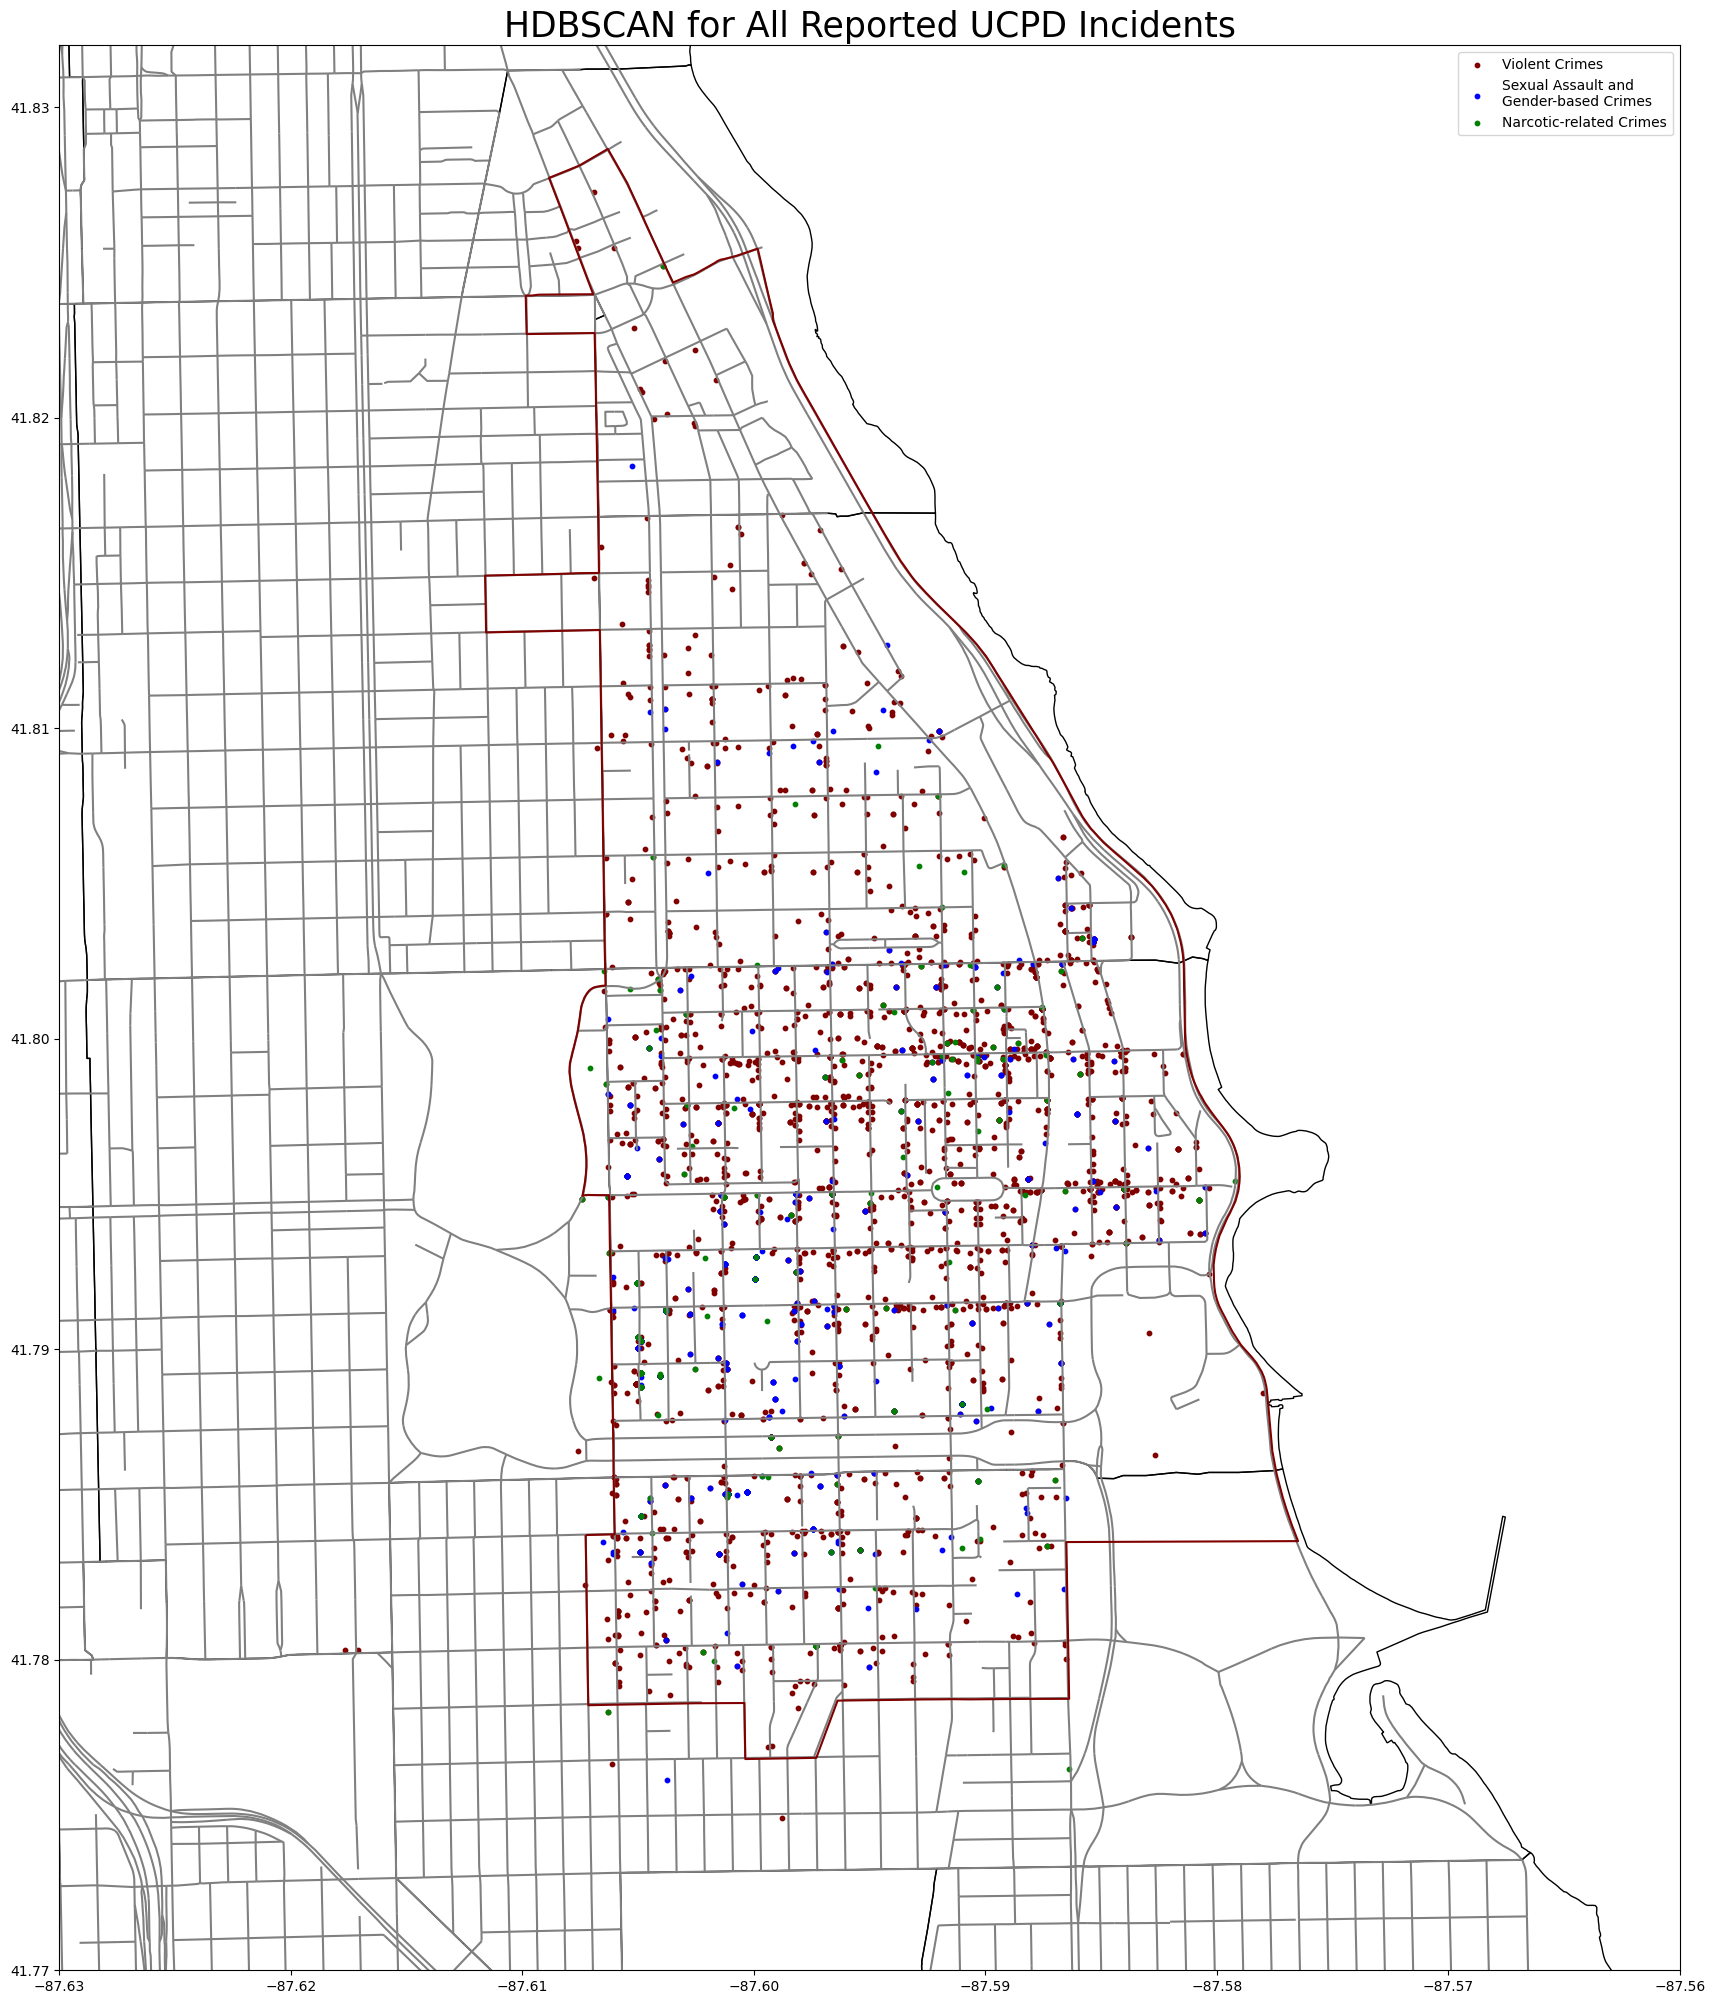

In [112]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)
chi_communities.to_crs(epsg=ESPG_NUM).plot(
    ax=ax, color="none", edgecolor="black"
)
chi_streets.to_crs(epsg=ESPG_NUM).plot(ax=ax, color="grey")
ucpd_patrol_area.to_crs(epsg=ESPG_NUM).plot(ax=ax, color="maroon")
ax.set_xlim(*VIEWPORT_X)
ax.set_ylim(*VIEWPORT_Y)
violence["All"].plot(
    ax=ax, markersize=10, color="maroon", label="Violent Crimes"
)
sa_gb["All"].plot(
    ax=ax,
    markersize=10,
    color="blue",
    label="Sexual Assault and\nGender-based Crimes",
)
narcotics["All"].plot(
    ax=ax, markersize=10, color="green", label="Narcotic-related Crimes"
)
plt.legend()
plt.title("HDBSCAN for All Reported UCPD Incidents", fontsize=25)
plt.savefig("all-crimes-overlap.png")

(2823, 2)
Estimated number of clusters for violent crimes: all seasons 2
Estimated number of noise points for violent crimes: all seasons 1791/2823


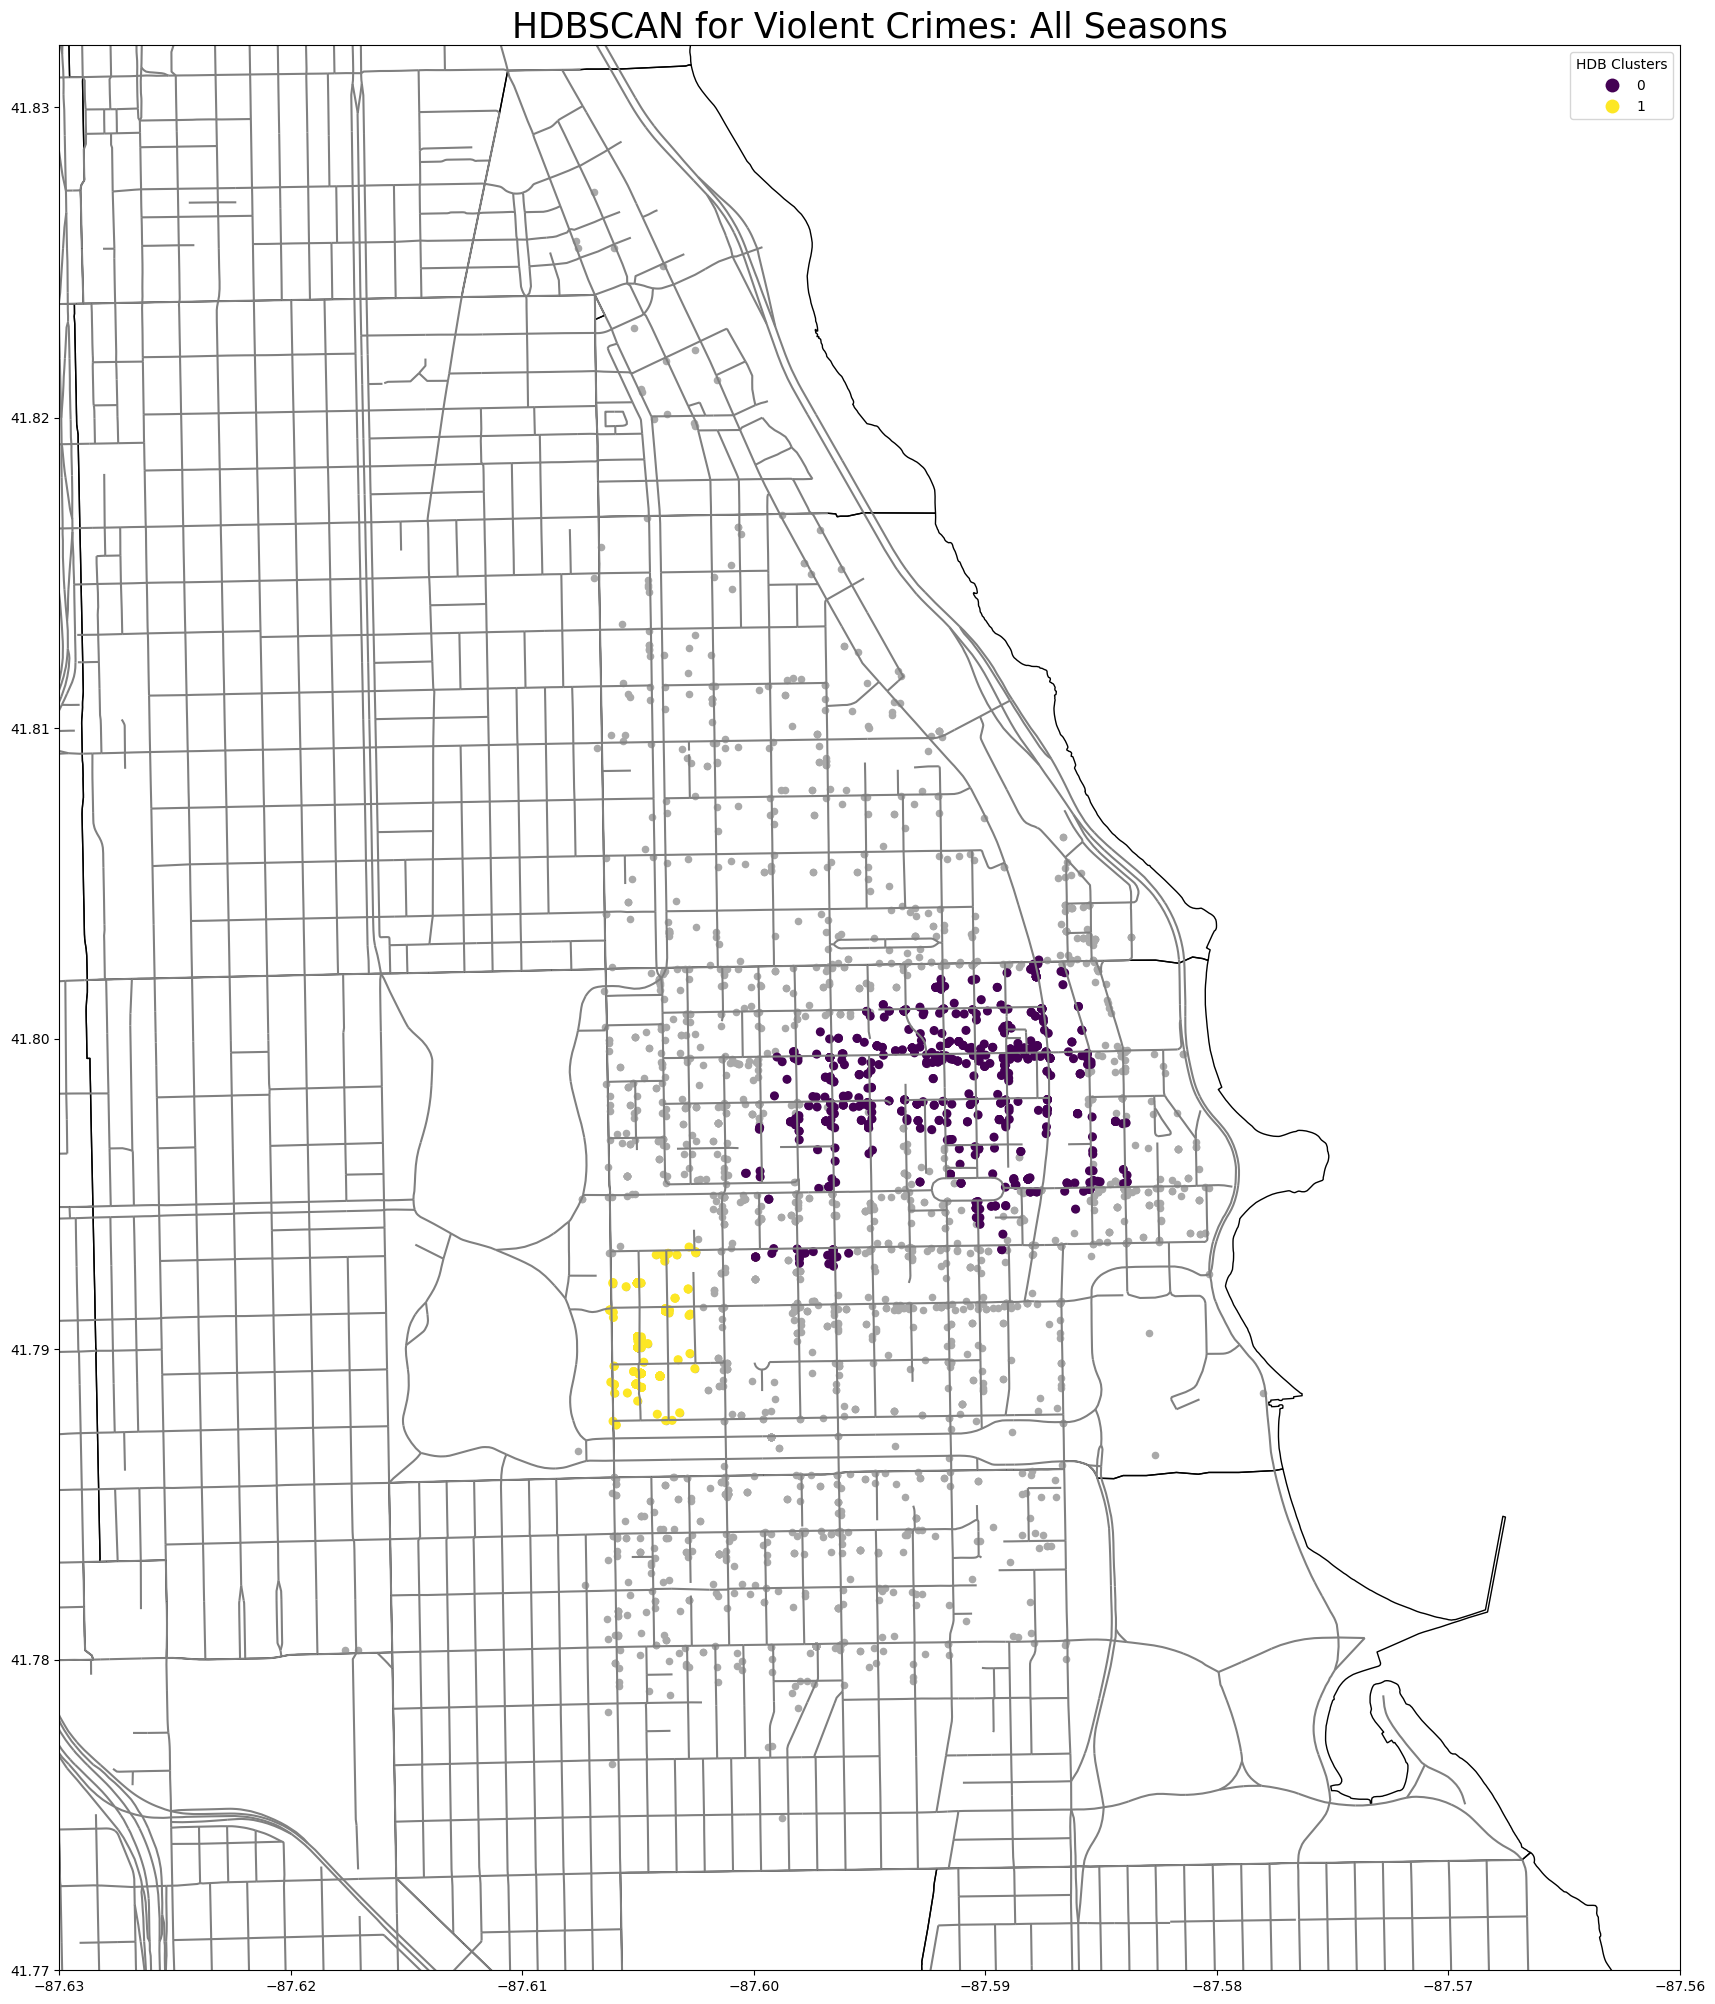

In [113]:
hdbscan_plotting(violence["All"], "violent crimes: all seasons")

(512, 2)
Estimated number of clusters for sexual assault and gender-based crimes: all seasons 8
Estimated number of noise points for sexual assault and gender-based crimes: all seasons 228/512


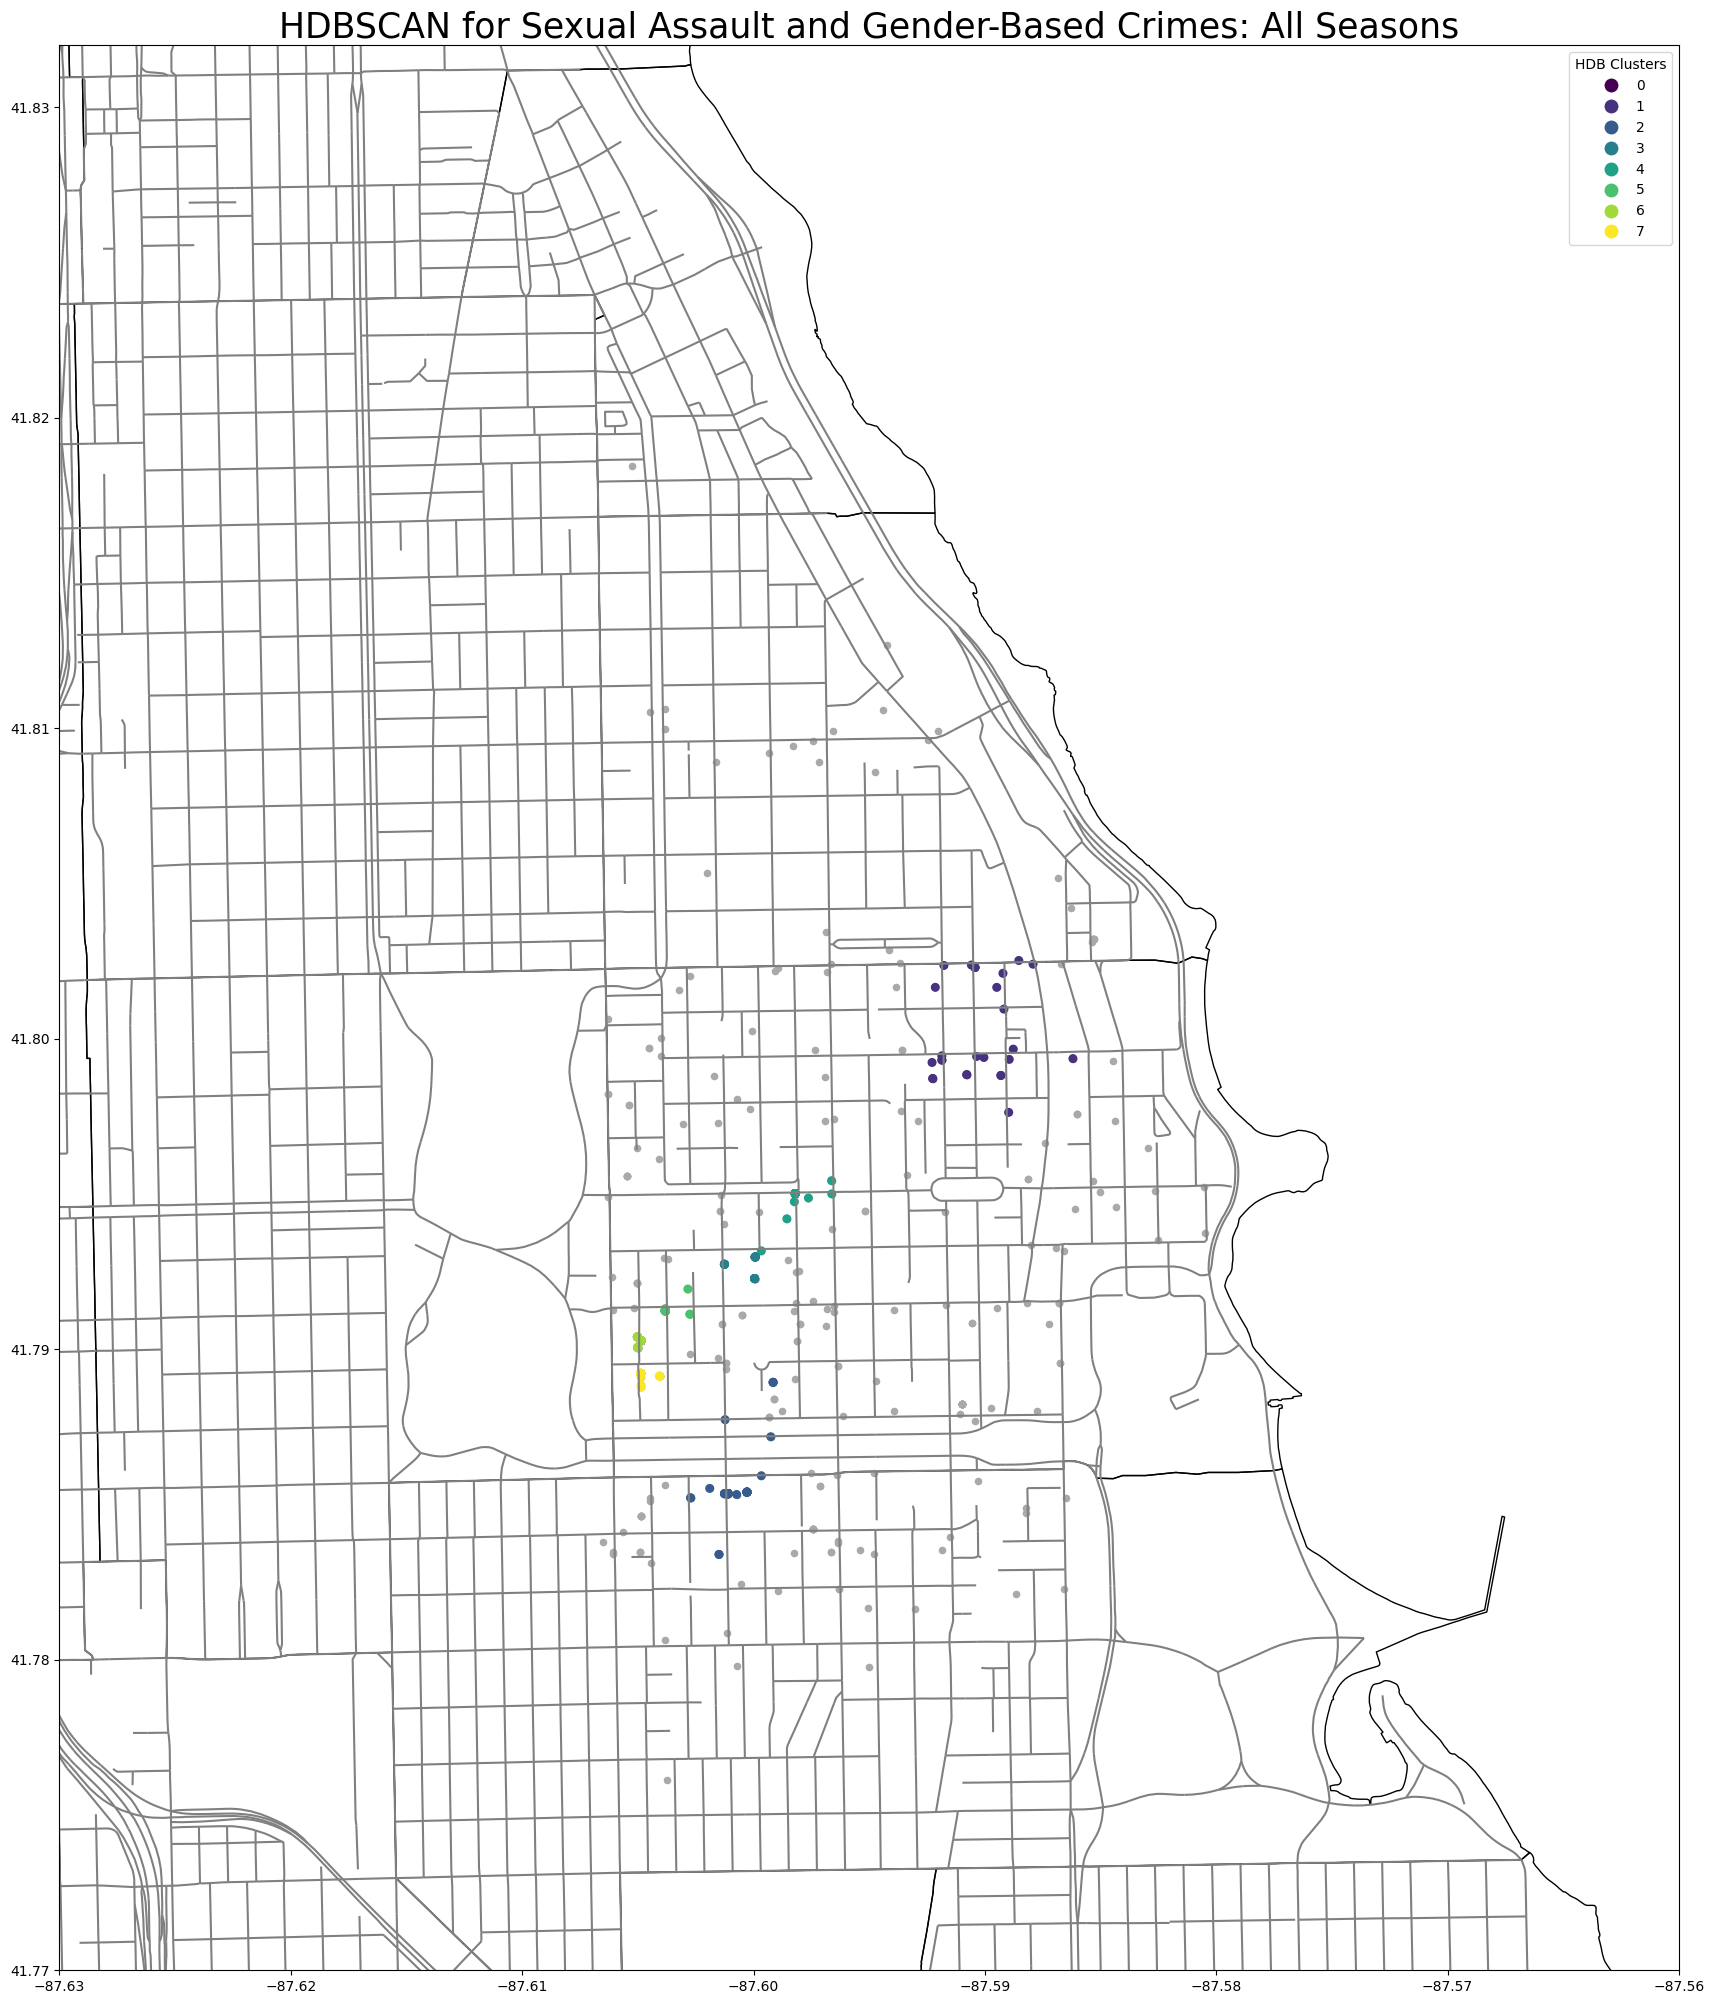

In [114]:
hdbscan_plotting(
    sa_gb["All"], "sexual assault and gender-based crimes: all seasons"
)

(342, 2)
Estimated number of clusters for narcotic-related crimes: all seasons 4
Estimated number of noise points for narcotic-related crimes: all seasons 105/342


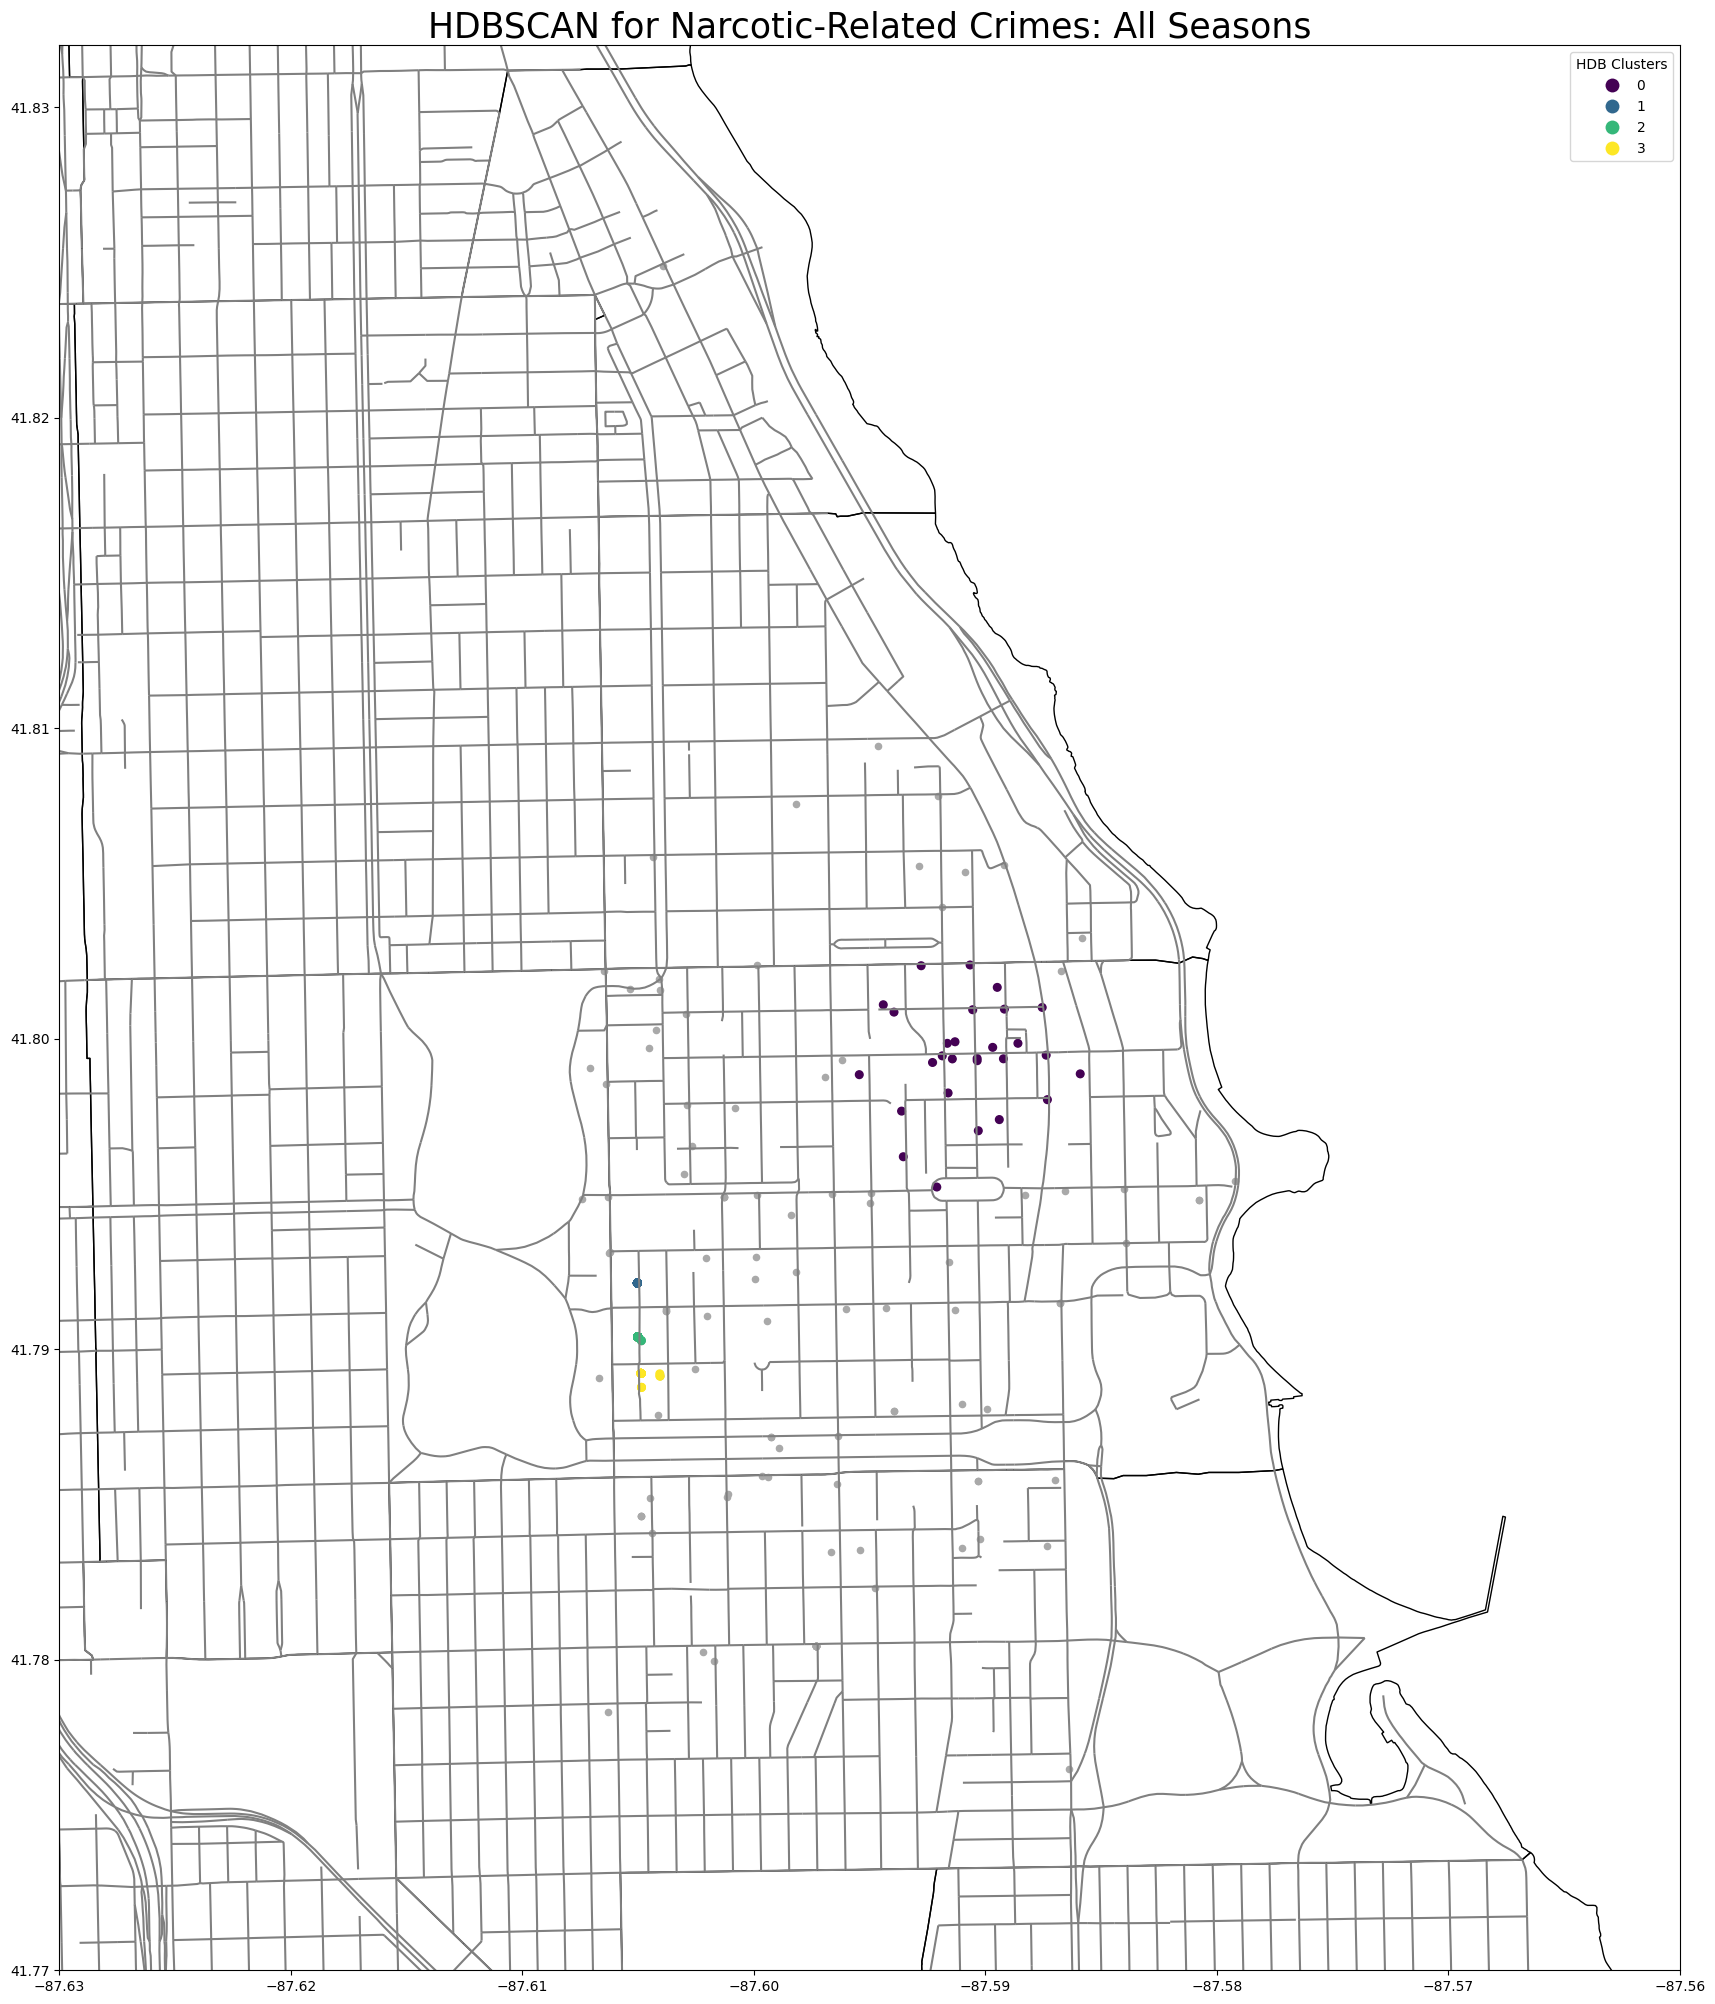

In [115]:
hdbscan_plotting(narcotics["All"], "narcotic-related crimes: all seasons")

In [116]:
def create_four_seasons_png(
    i_dict: {str: gp.GeoDataFrame}, category: str
) -> None:
    q_fig, q_ax = plt.subplots(2, 2, figsize=FIGURE_SIZE)

    q_fig.subplots_adjust(top=0.94)
    for qx in q_ax.flat:
        chi_communities.to_crs(epsg=ESPG_NUM).plot(
            ax=qx, color="none", edgecolor="black", zorder=1
        )
        chi_streets.to_crs(epsg=ESPG_NUM).plot(ax=qx, color="grey", zorder=2)
        qx.set_xlim(*VIEWPORT_X)
        qx.set_ylim(*VIEWPORT_Y)

    # Spring Image
    spring_df = i_dict["Spring"][i_dict["Spring"].hdb_cluster != "-1"]
    i_dict["Spring"].plot(
        ax=q_ax[0, 0], markersize=5, color="darkgrey", zorder=3
    )
    spring_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[0, 0],
        cmap="viridis",
        legend=True,
        markersize=10,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[0, 0].set_title(f"HDBSCAN Clusters for {category} Crimes: Spring")

    # Summer Image
    summer_df = i_dict["Summer"][i_dict["Summer"].hdb_cluster != "-1"]
    i_dict["Summer"].plot(
        ax=q_ax[0, 1], markersize=5, color="darkgrey", zorder=3
    )
    summer_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[0, 1],
        cmap="viridis",
        legend=True,
        markersize=10,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[0, 1].set_title(f"HDBSCAN Clusters for {category} Crimes: Summer")

    # Fall Image
    fall_df = i_dict["Fall"][i_dict["Fall"].hdb_cluster != "-1"]
    i_dict["Fall"].plot(ax=q_ax[1, 0], markersize=5, color="darkgrey", zorder=3)
    fall_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[1, 0],
        cmap="viridis",
        legend=True,
        markersize=10,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[1, 0].set_title(f"HDBSCAN Clusters for {category} Crimes: Fall")

    # Winter Image
    winter_df = i_dict["Winter"][i_dict["Winter"].hdb_cluster != "-1"]
    i_dict["Winter"].plot(
        ax=q_ax[1, 1], markersize=5, color="darkgrey", zorder=3
    )
    winter_df.plot(
        column=CLUSTER_KEY,
        ax=q_ax[1, 1],
        cmap="viridis",
        legend=True,
        markersize=10,
        legend_kwds={
            "loc": "upper right",
            "title": "HDB Clusters",
        },
        zorder=4,
    )
    q_ax[1, 1].set_title(f"HDBSCAN Clusters for {category} Crimes: Winter")

    q_fig.suptitle(f"Seasonal HDBSCANs for {category} Crimes", fontsize=25)

    plt.savefig(f"{category.lower()}-seasons.png")

AttributeError: 'GeoDataFrame' object has no attribute 'hdb_cluster'

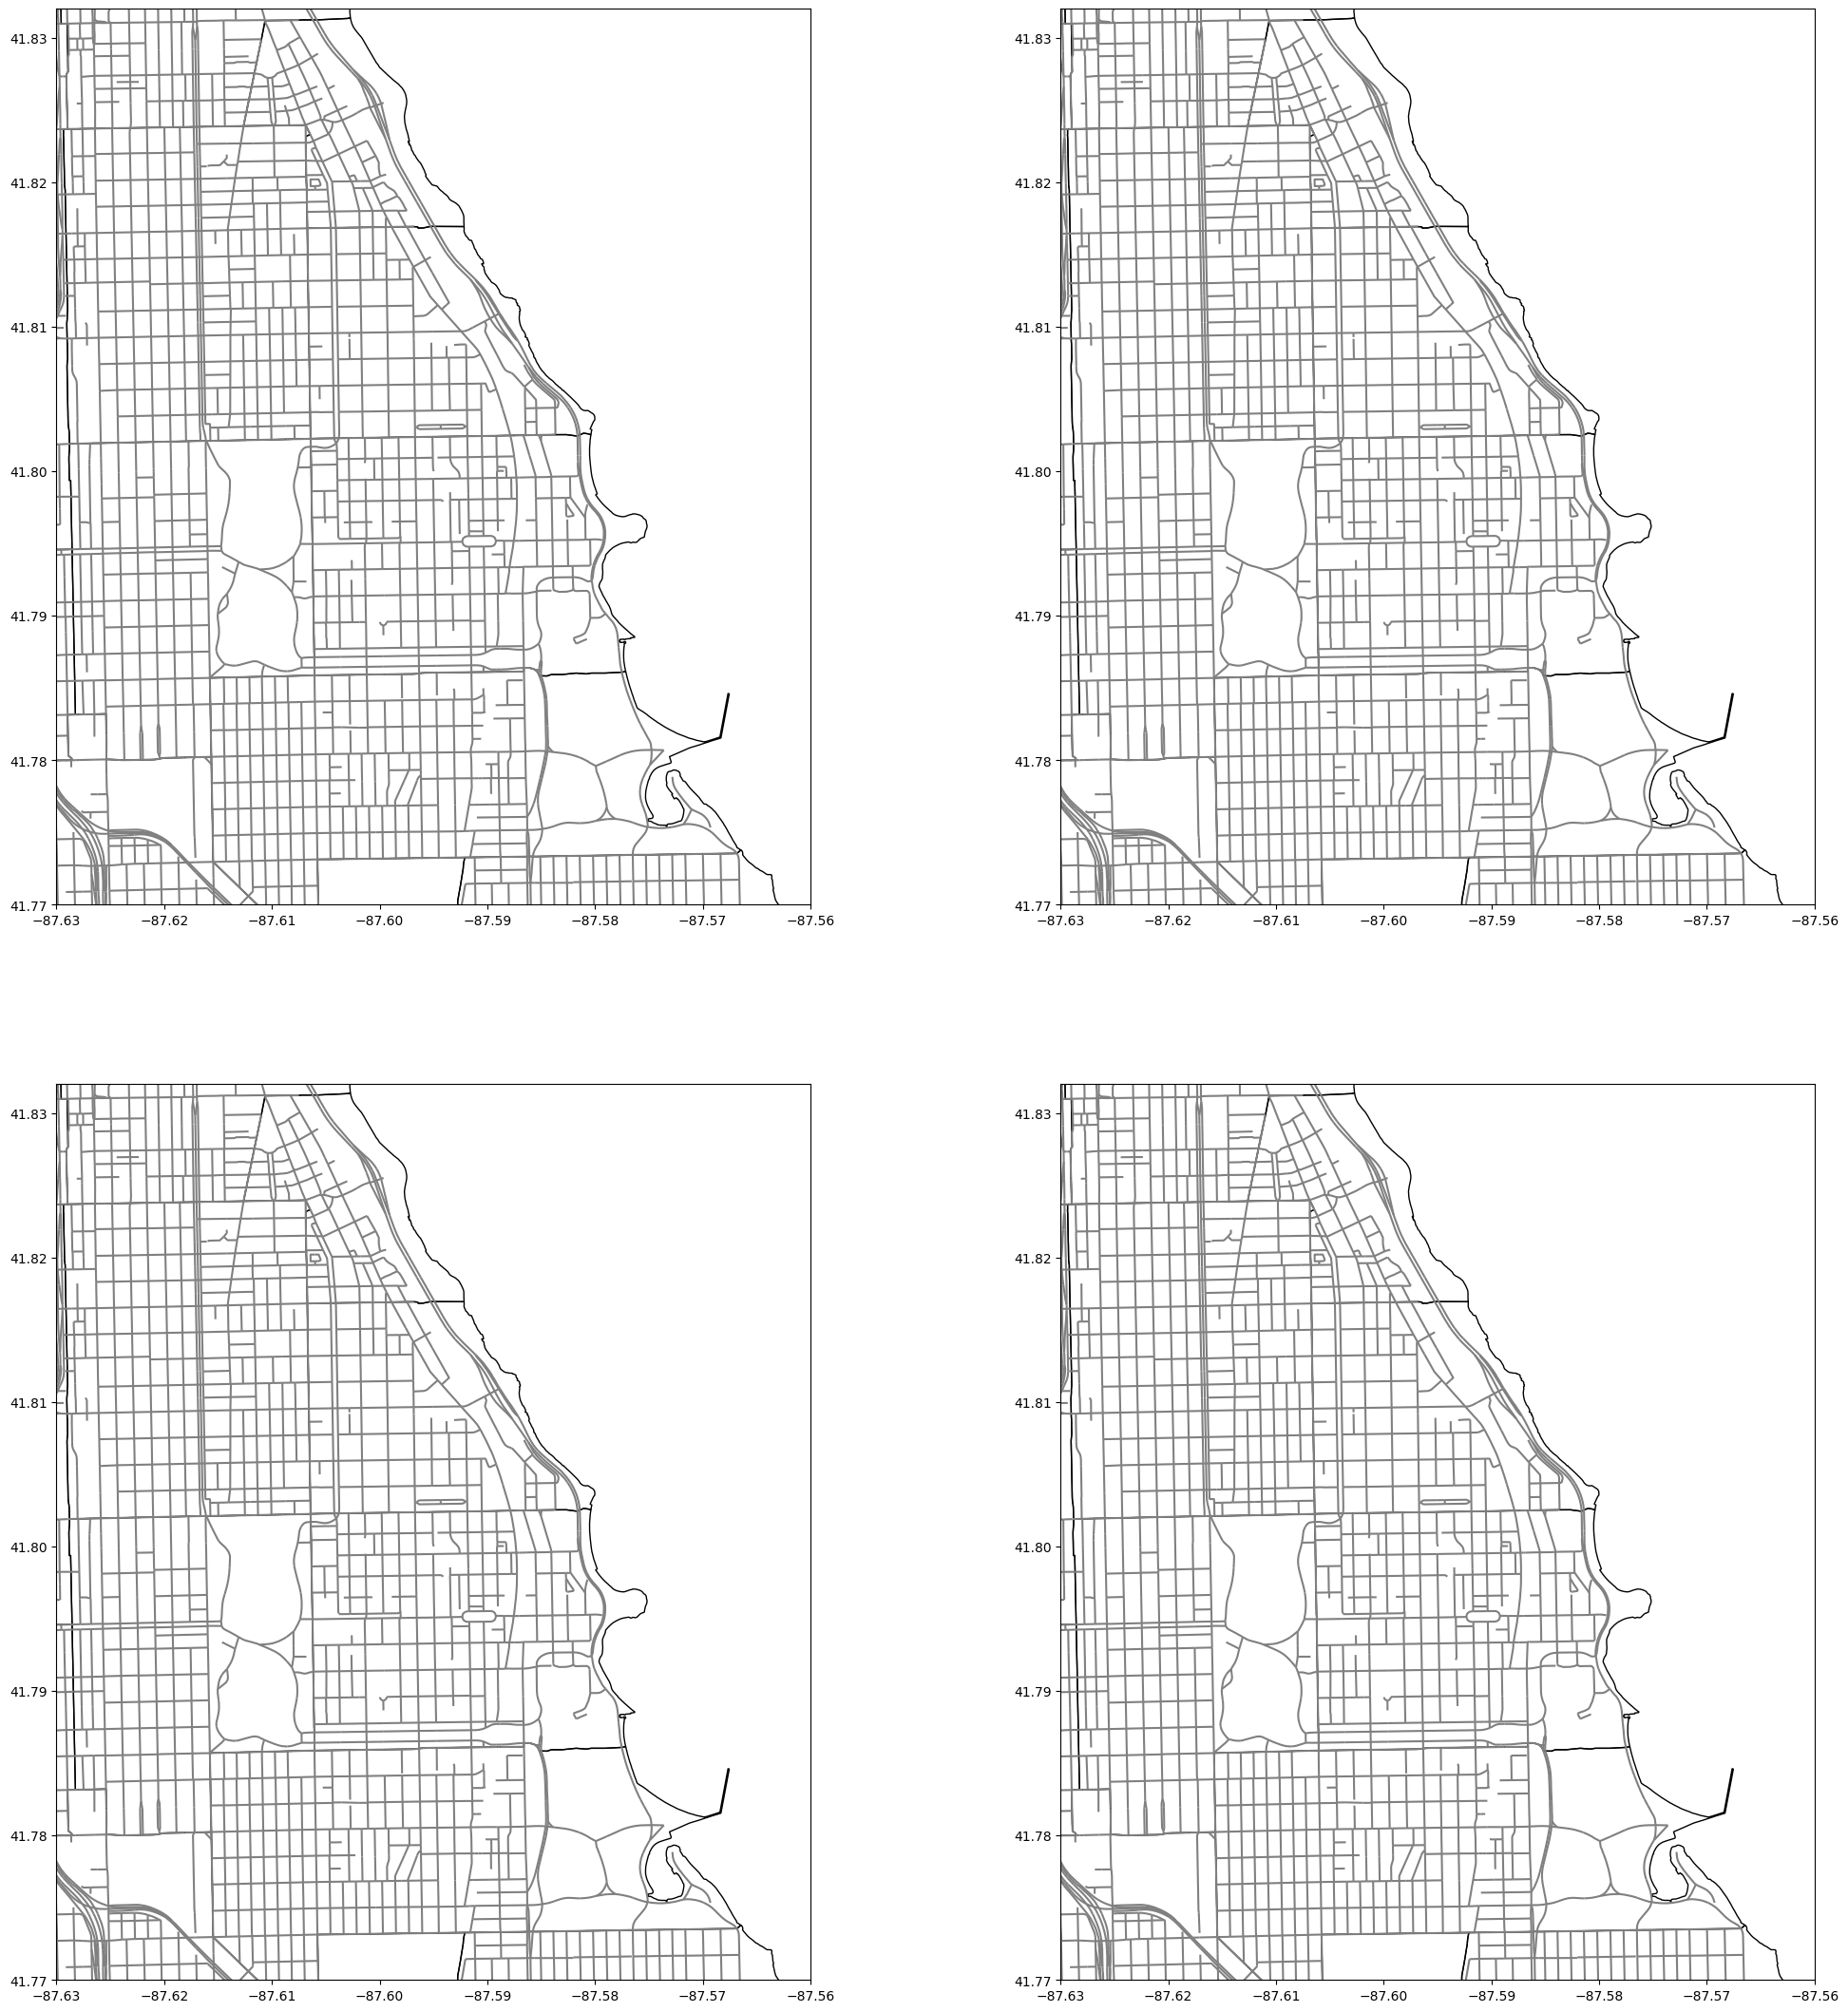

In [117]:
create_four_seasons_png(violence, "Violent")

In [ ]:
create_four_seasons_png(sa_gb, "Sexual Assault and Gender-based")

In [ ]:
create_four_seasons_png(narcotics, "Narcotics-related")